### 1 MODELO PROPHET:

Cargamos Librerias

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import statsmodels.api as sm
from statsmodels.tsa.holtwinters import ExponentialSmoothing
from statsmodels.tsa.stattools import adfuller, kpss
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.graphics.tsaplots import plot_acf
from statsmodels.tsa.stattools import acf
from sklearn.metrics import mean_squared_error, mean_absolute_error
from sklearn.linear_model import LinearRegression
import matplotlib
from statsmodels.graphics.tsaplots import plot_pacf
from itertools import product 
from prophet import Prophet

c:\Users\marco\anaconda3\envs\ldi2_cuda\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


Cargamos el dataset

In [23]:
df = pd.read_csv('Geochemical_Checklist.csv', sep=',') # leemos el archivo csv
pd.set_option('display.max_columns', None) # lo que realizamos aquí es que se muestren todas las columnas
#print(df.head(5)) # mostramos las primeras 5 filas

Breve resumen del dataset

In [24]:
#mostramos las columnas que tenemos y su tipo de dato
print(df.dtypes)

Project                     object
Despach N° RA-20XX-XXXX     object
SampleID_Init               object
SampleID_Fin                object
TotalSample_SE               int64
Weight SE                  float64
SampleType                  object
Target                      object
Laboratory                  object
Prepared Method             object
Analytical Method           object
DispatchDate                object
Over Limit                  object
Analytes                    object
ReceivedDate                object
ResultDate                  object
Workorder                   object
Location                    object
Responsible                 object
dtype: object


In [25]:
#transformamos las fechas a tipo datetime (dispatchDate, ReceivedDate,Resultdate) mes,dia,año
df['DispatchDate'] = pd.to_datetime(df['DispatchDate'])
df['ReceivedDate'] = pd.to_datetime(df['ReceivedDate'])
df['ResultDate'] = pd.to_datetime(df['ResultDate'])

Modelo Prophet sin Regresores (solo : 'ds','y')

              TotalSample_SE
DispatchDate                
2021-11-22               144
2021-11-30                81
2021-12-17                84
2022-01-13                26
2022-01-24                99


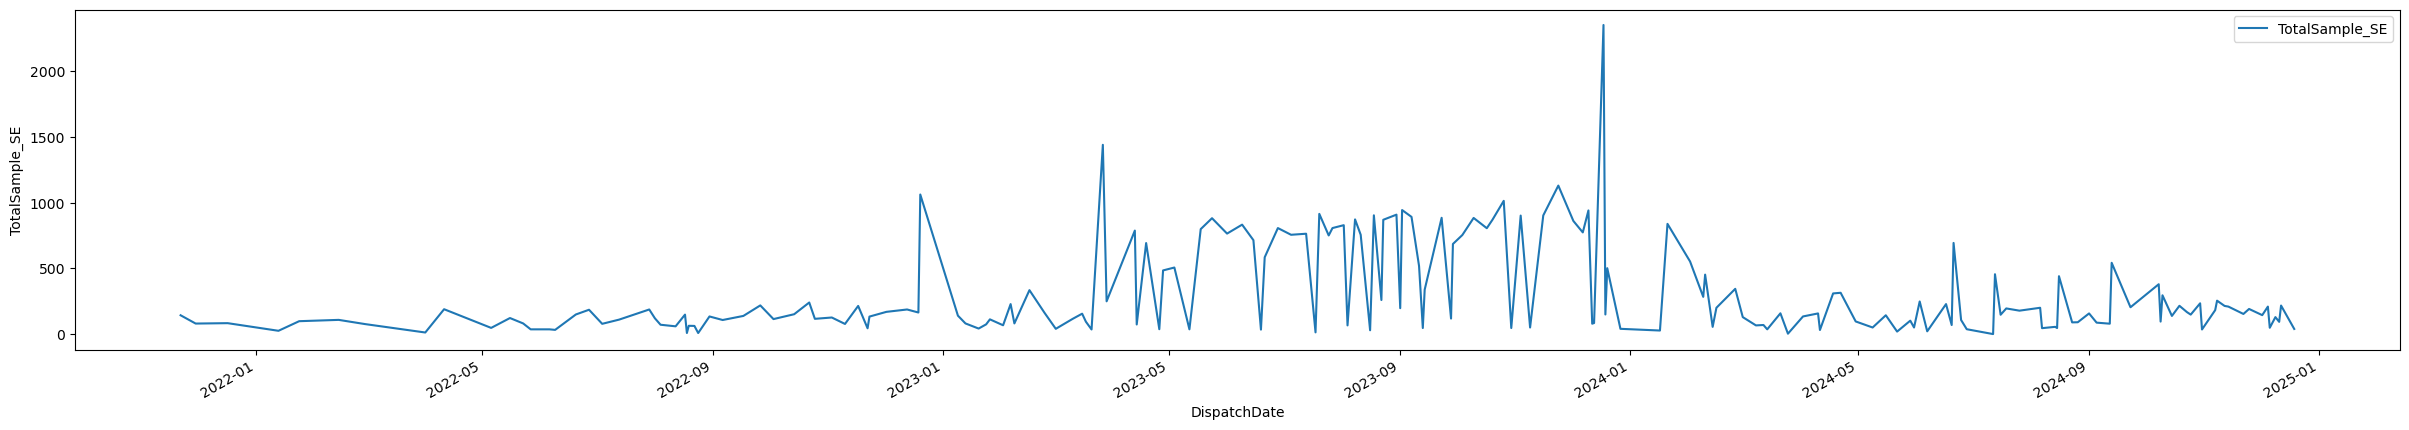

In [28]:
# Agrupamos la sumatoria de TotalSample_SE en las mismas fechas
#convertimos en categoricas
#convertimos algunos features en categoricas.
df_dispatchdate = df[[ 'TotalSample_SE','DispatchDate']]
df_dispatchdate_agrupado = df_dispatchdate.groupby('DispatchDate').sum()
print(df_dispatchdate_agrupado.head(5))

# Graficamos
df_dispatchdate_agrupado.plot(figsize=(30, 5))
plt.xlabel('DispatchDate')
plt.ylabel('TotalSample_SE')
plt.show()

In [29]:
#Convertimos el dataframe a un formato que pueda ser leido por Prophet
df_dispatchdate= df_dispatchdate.rename(columns = {'DispatchDate':'ds', 'TotalSample_SE':'y',})
# Agregamos la suma de 'y' por 'ds'
df_dispatchdate = df_dispatchdate.groupby('ds')['y'].sum().reset_index()

14:28:16 - cmdstanpy - INFO - Chain [1] start processing
14:28:16 - cmdstanpy - INFO - Chain [1] done processing


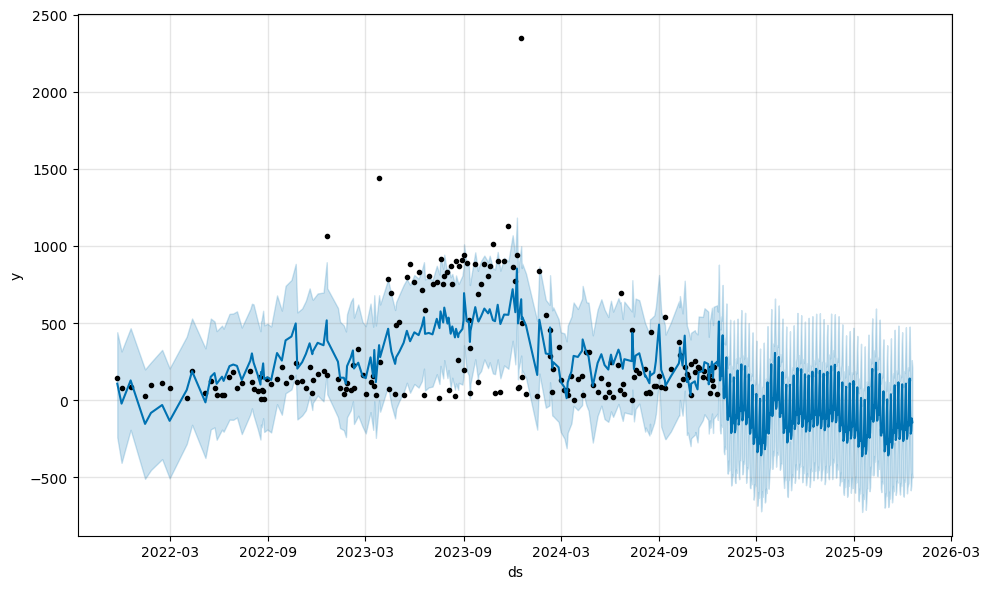

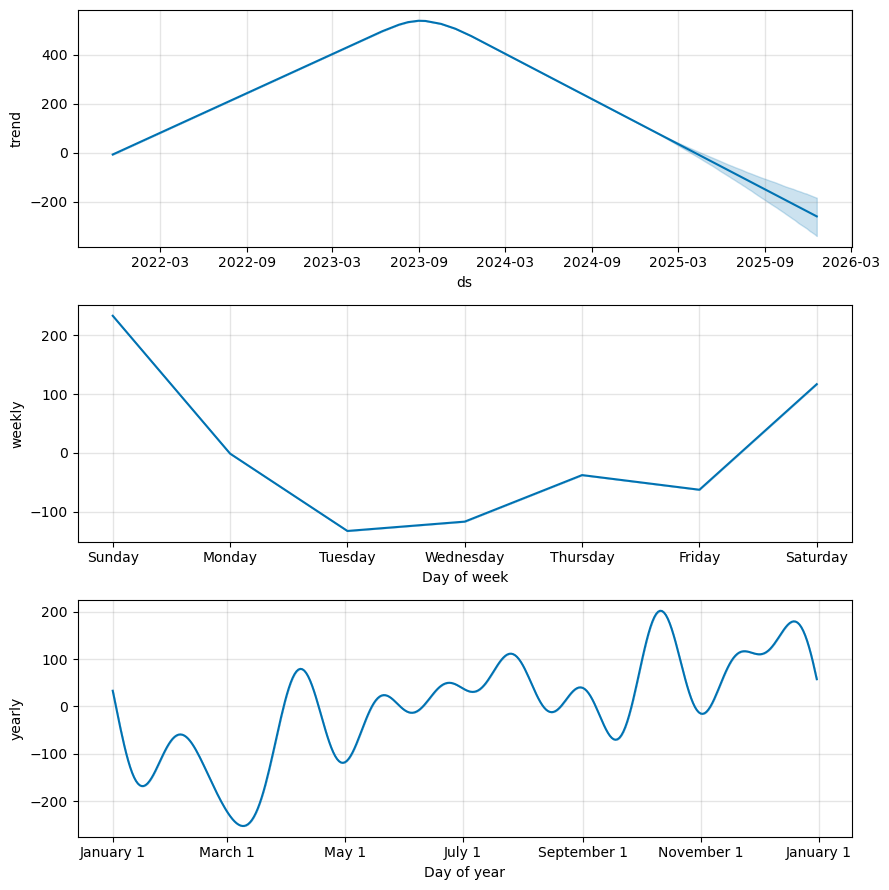

In [30]:
#creamos el modelo de predicción
model = Prophet()
model.fit(df_dispatchdate)
future = model.make_future_dataframe(periods=365)
forecast = model.predict(future)
model.plot(forecast)
plt.show()
model.plot_components(forecast)
plt.show()

In [32]:

# Calculamos las métricas de evaluación
y_true = df_dispatchdate['y']  # Valores reales
y_pred = forecast['yhat'][:len(df_dispatchdate)]  # Predicciones para el período histórico

mse = mean_squared_error(y_true, y_pred)
rmse = mean_squared_error(y_true, y_pred, squared=False)
mae = mean_absolute_error(y_true, y_pred)

# Mostramos las métricas
print(f"MSE: {mse}")
print(f"RMSE: {rmse}")
print(f"MAE: {mae}")


MSE: 73772.17270317863
RMSE: 271.6103324676339
MAE: 196.1165100859429


c:\Users\marco\anaconda3\envs\ldi2_cuda\Lib\site-packages\sklearn\metrics\_regression.py:492: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(


Modelo Prophet con Regresores

In [3]:
df = pd.read_csv('Geochemical_Checklist.csv', sep=',') # leemos el archivo csv
pd.set_option('display.max_columns', None) # lo que realizamos aquí es que se muestren todas las columnas
#print(df.head(5)) # mostramos las primeras 5 filas
#transformamos las fechas a tipo datetime (dispatchDate, ReceivedDate,Resultdate) mes,dia,año
df['DispatchDate'] = pd.to_datetime(df['DispatchDate'])
df['ReceivedDate'] = pd.to_datetime(df['ReceivedDate'])
df['ResultDate'] = pd.to_datetime(df['ResultDate'])

In [4]:
#convertimos en categoricas
#convertimos algunos features en categoricas.
df['SampleType'] = df['SampleType'].astype('category')
df['Target'] = df['Target'].astype('category')
df_dispatchdate = df[['TotalSample_SE', 'DispatchDate','Despach N° RA-20XX-XXXX','SampleType','Analytical Method','Project']]

In [5]:
df_dispatchdate= df_dispatchdate.rename(columns = {'DispatchDate':'ds', 'TotalSample_SE':'y','Despach N° RA-20XX-XXXX':'despatch_n'})

In [6]:
df_dispatchdate.head()

,y,ds,despatch_n,SampleType,Analytical Method,Project
0,2,2022-05-16,RA-2022-0013,RockChip,ME-MS61L+ME-MS81,BRAL
1,4,2022-06-27,RA-2022-0024,RockChip,ME-MS61L+ME-MS81,BRAL
2,13,2022-06-27,RA-2022-0025,Soil,ME-MS61L+ME-MS81,BRAL
3,10,2022-06-27,RA-2022-0027,StreamSed,ME-MS61L+ME-MS81+Au-ICP22,BRAL
4,8,2022-07-13,RA-2022-0035,Soil,ME-MS61L+ME-MS81,BRAL


In [7]:
# Tabla con la suma de 'y'
df_suma = df_dispatchdate.groupby('ds')['y'].sum().reset_index()

# Tabla con las columnas categóricas (tomamos el primer valor de cada categoría por fecha)
df_categorias = df_dispatchdate.groupby('ds')[['SampleType','Project' , 'Analytical Method']].first().reset_index() #reset index sirve para resetear el index es decir que el index sea el numero de la fila 

# Unimos las dos tablas
df_dispatchdate_agrupado = pd.merge(df_suma, df_categorias, on='ds')

In [8]:
df_dispatchdate_agrupado.head(70)

,ds,y,SampleType,Project,Analytical Method
0,2021-11-22,144,StreamSed,BRAU,ME-MS61L+Au-ICP22
1,2021-11-30,81,StreamSed,BRAU,ME-MS61L+Au-ICP22
2,2021-12-17,84,StreamSed,BRAU,ME-MS61L+Au-ICP22
3,2022-01-13,26,RockChip,BRAR,ME-MS61L+ME-MS81+Au-ICP22
4,2022-01-24,99,RockChip,BRAR,ME-MS61L+ME-MS81+Au-ICP22
...,...,...,...,...,...
65,2023-04-26,38,RockChip,BRNE,ME-MS61L+ME-MS81
66,2023-04-28,485,RC,BRAR,ICP95A / IMS95A
67,2023-05-04,507,RockChip,BRAL,ME-MS61L+ME-MS81
68,2023-05-12,37,StreamSed,BRBA,ME-MS61L+Au-ICP22


In [9]:
df_dummies= pd.get_dummies(df_dispatchdate_agrupado, columns=['SampleType','Project','Analytical Method']) #creamos las variables dummies, columns signi
#exportamos el dataset en un csv
df_dummies.to_csv('df_dummies2.csv', index=False)


In [11]:
#separamos en train y future. Para future tomamos los ultimos 6 meses
future = df_dummies[df_dummies['ds'] >= '2024-06-01']
train = df_dummies[df_dummies['ds'] < '2024-06-01']

In [12]:
model = Prophet()
# Regresores
regresores = [col for col in df_dummies.columns if col not in ['ds', 'y']]
print(regresores)

['SampleType_Auger', 'SampleType_Channel', 'SampleType_DDH', 'SampleType_New Extraction Test', 'SampleType_Pulp', 'SampleType_RC', 'SampleType_RockChip', 'SampleType_RockChipP', 'SampleType_Soil', 'SampleType_StreamSed', 'Project_BRAL', 'Project_BRAR', 'Project_BRAU', 'Project_BRBA', 'Project_BRGO', 'Project_BRJA', 'Project_BRMG', 'Project_BRNE', 'Analytical Method_Au-ICP22', 'Analytical Method_ICP95A / IMS95A', 'Analytical Method_IMS95RS', 'Analytical Method_ME-MS61L+Au-ICP22', 'Analytical Method_ME-MS61L+ME-MS61L-REE', 'Analytical Method_ME-MS61L+ME-MS61L-REE+Au-ICP22', 'Analytical Method_ME-MS61L+ME-MS81', 'Analytical Method_ME-MS61L+ME-MS81+Au-ICP22', 'Analytical Method_ME-MS61L+ME-MS81+PGM-ICP24', 'Analytical Method_ME-MS61L+ME-MS81+PGM-ICP27', 'Analytical Method_ME-MS61L+PGM-ICP24', 'Analytical Method_ME-MS89L', 'Analytical Method_PULPRP_G2+ICP95A/IMS95A', 'Analytical Method_TRSPEC-20']


In [15]:
# Agregamos los regresores al modelo
for reg in regresores:
    model.add_regressor(reg)

# Ajustamos el modelo
model.fit(df_dummies)  # Asegúrate de que 'df' contenga las columnas 'ds', 'y' y los regresores

22:35:12 - cmdstanpy - INFO - Chain [1] start processing
22:35:12 - cmdstanpy - INFO - Chain [1] done processing


In [16]:
forecast = model.predict(future)
forecast[['ds', 'yhat', 'yhat_lower', 'yhat_upper']].tail()

,ds,yhat,yhat_lower,yhat_upper
42,2024-12-06,82.515290,-165.267543,330.031737
43,2024-12-09,276.451625,26.173607,521.614650
44,2024-12-11,223.653155,-9.045166,489.369621
45,2024-12-12,264.762867,14.507397,514.755543
46,2024-12-19,371.846837,114.819083,632.545395


In [17]:
def mean_absolute_percentage_error(y_true, y_pred):
    return np.mean(np.abs((y_true - y_pred) / y_true)) * 100

def evaluate_forecast(y_true, y_pred):
    mae = mean_absolute_error(y_true, y_pred)
    mse = mean_squared_error(y_true, y_pred)
    return mae, mse,

y_true = future['y']  # Valores reales de la serie original
y_pred = forecast['yhat']  # Predicciones de la serie forecast ('yhat' es la predicción puntual)

mae, mse = evaluate_forecast(y_true, y_pred)

# Mostrar resultados
print(f"Métricas de pronóstico versus futuro:")
print(f"MAE: {mae}")
print(f"MSE: {mse}")


Métricas de pronóstico versus futuro:
MAE: 102.57324863006232
MSE: 17524.809641032796


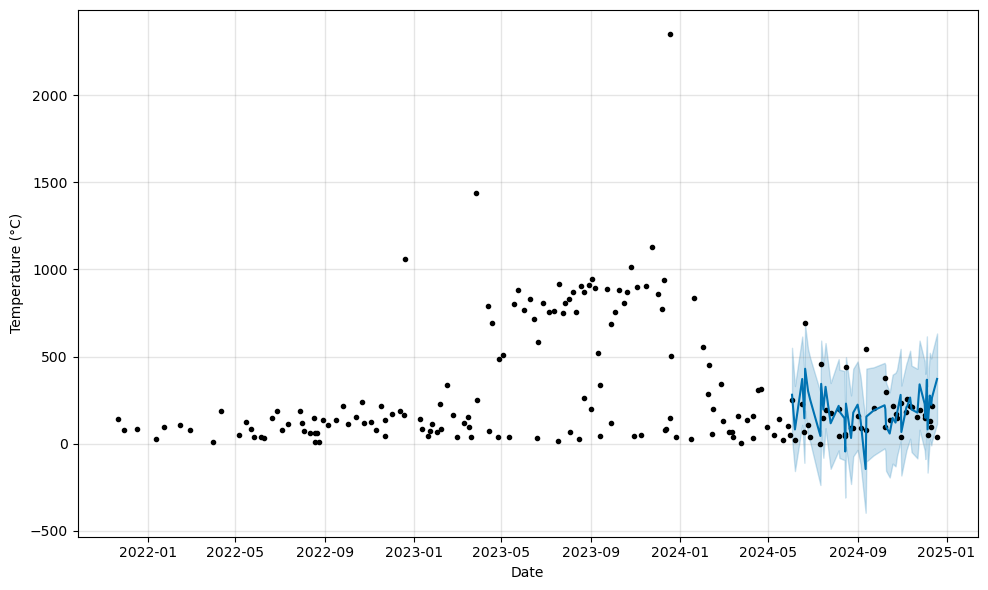

In [18]:
model.plot(forecast)
plt.xlabel('Date')
plt.ylabel('Temperature (°C)')
plt.show()

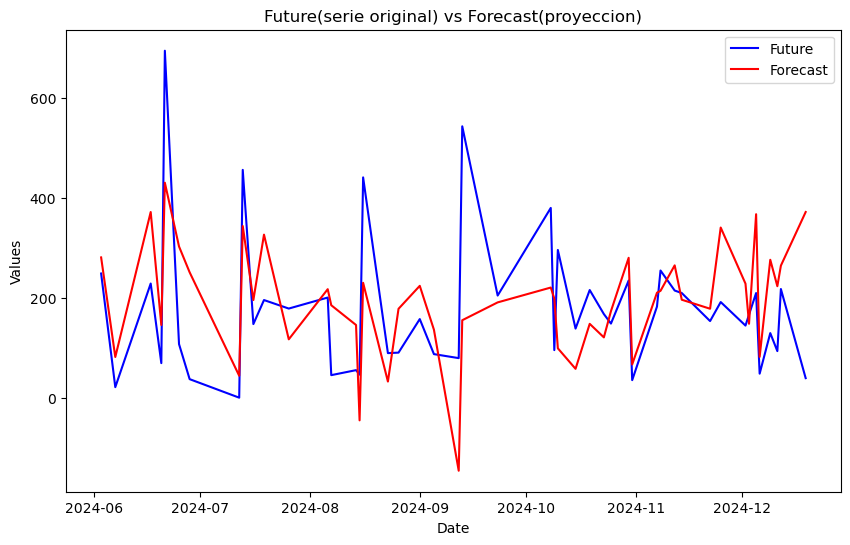

In [19]:

plt.figure(figsize=(10, 6))

plt.plot(future['ds'], future['y'], label='Future', color='blue')

plt.plot(forecast['ds'], forecast['yhat'], label='Forecast', color='red')

plt.xlabel('Date')
plt.ylabel('Values')
plt.title('Future(serie original) vs Forecast(proyeccion)')
plt.legend()

# gráfico
plt.show()


In [ ]:
#ahora realizamos una prediccion hacia el futuro de los proximos 6 meses
future = model.make_future_dataframe(periods=180)
future.to_csv('future2.csv', index=False)

Neural Prophet

In [2]:
from neuralprophet import NeuralProphet
from neuralprophet import set_random_seed

set_random_seed(0)

df = pd.read_csv('Geochemical_Checklist.csv', sep=',') # leemos el archivo csv
pd.set_option('display.max_columns', None) # lo que realizamos aquí es que se muestren todas las columnas
#print(df.head(5)) # mostramos las primeras 5 filas
df['DispatchDate'] = pd.to_datetime(df['DispatchDate'])
df['ReceivedDate'] = pd.to_datetime(df['ReceivedDate'])
df['ResultDate'] = pd.to_datetime(df['ResultDate'])


Importing plotly failed. Interactive plots will not work.
Importing plotly failed. Interactive plots will not work.


In [3]:
# Seleccionamos las columnas relevantes
df_dispatchdate = df[[ 'TotalSample_SE','DispatchDate']]

# Renombramos las columnas
df_dispatchdate = df_dispatchdate.rename(columns = {'DispatchDate':'ds', 'TotalSample_SE':'y'})

# Agregamos la suma de 'y' por 'ds'
df_dispatchdate = df_dispatchdate.groupby('ds')['y'].sum().reset_index()

demand_df = df_dispatchdate.copy()


In [10]:
print(demand_df.shape)


(192, 2)


In [4]:
import pandas as pd

# Supongamos que 'df' es tu DataFrame, ordenado por fecha.

# Alternativa 1 (80/10/10)
train_size = int(len(demand_df) * 0.8)
valid_size = (len(demand_df) - train_size) // 2

df_train = demand_df[:train_size]
df_valid = demand_df[train_size: train_size + valid_size]
df_test = demand_df[train_size + valid_size:]

print(f"Alternativa 1: Train={len(df_train)}, Valid={len(df_valid)}, Test={len(df_test)}")


# Alternativa 2 (75/12.5/12.5)
train_size = int(len(demand_df) * 0.75)
valid_size = int(len(demand_df) * 0.125) # Calculo explicito
# valid_size = (len(df) - train_size) // 2  #Tambien se podria usar division entera.

df_train = demand_df[:train_size]
df_valid = demand_df[train_size: train_size + valid_size]
df_test = demand_df[train_size + valid_size:]


print(f"Alternativa 2: Train={len(df_train)}, Valid={len(df_valid)}, Test={len(df_test)}")

#Verificacion de indices
if isinstance(demand_df.index, pd.RangeIndex):
    assert df_train.index.max() < df_valid.index.min()
    assert df_valid.index.max() < df_test.index.min()
elif isinstance(demand_df.index, pd.DatetimeIndex):
    assert df_train['ds'].max() < df_valid['ds'].min()
    assert df_valid['ds'].max() < df_test['ds'].min()

Alternativa 1: Train=153, Valid=19, Test=20
Alternativa 2: Train=144, Valid=24, Test=24


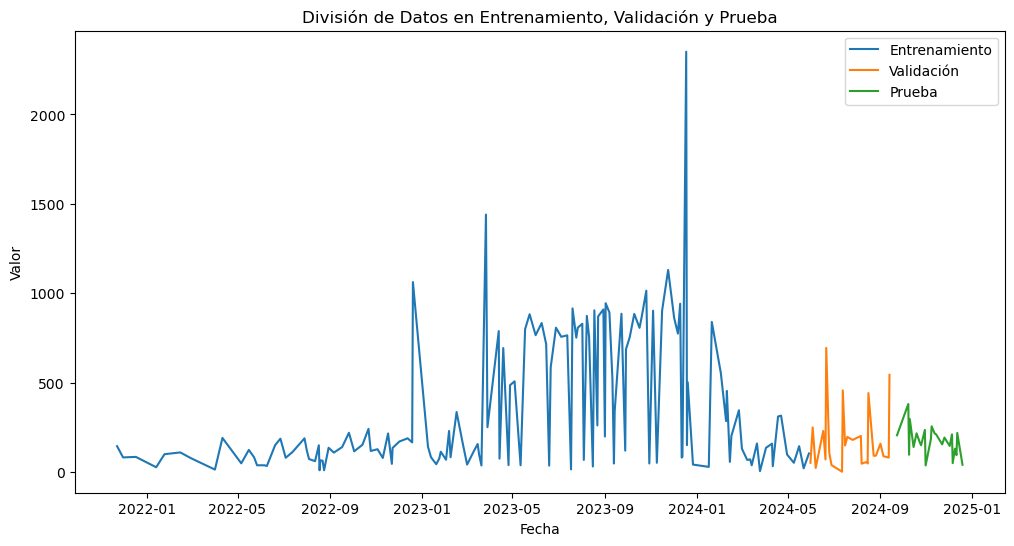

In [5]:
import matplotlib.pyplot as plt

plt.figure(figsize=(12, 6))
plt.plot(df_train['ds'], df_train['y'], label='Entrenamiento')
plt.plot(df_valid['ds'], df_valid['y'], label='Validación')
plt.plot(df_test['ds'], df_test['y'], label='Prueba')
plt.legend()
plt.xlabel('Fecha')
plt.ylabel('Valor')
plt.title('División de Datos en Entrenamiento, Validación y Prueba')
plt.show()

In [ ]:

from pytorch_lightning import Trainer

m = NeuralProphet(log_file="./logs.txt")

#m.add_country_holidays(country_name='Australia')
metrics = m.fit(df=df_train, validation_df=df_valid, freq="W", progress="plot-all")
metrics[-1:]

TypeError: NeuralProphet.__init__() got an unexpected keyword argument 'log_file'

In [26]:
from neuralprophet import NeuralProphet
from pytorch_lightning import loggers as pl_loggers
import pandas as pd
import os
import matplotlib.pyplot as plt
from sklearn.metrics import mean_absolute_error
from pytorch_lightning.loggers import CSVLogger


# --- Carga y preparación de datos ---

# Aquí, carga tus datos reales en un DataFrame llamado 'df'.
# Asegúrate de que tenga las columnas 'ds' (fecha, tipo datetime64) e 'y' (valor).
# Este es solo un EJEMPLO de creación de datos.  Reemplázalo con tu carga de datos.

df = pd.DataFrame(demand_df)
df['ds'] = pd.to_datetime(df['ds'])
df = df.sort_values(by='ds').reset_index(drop=True)
# df = pd.read_csv("ruta/a/tu/archivo.csv")  # Descomenta esto si lees desde un archivo.

# --- División de datos (75/12.5/12.5) ---
train_size = int(len(df) * 0.75)
valid_size = int(len(df) * 0.125)

df_train = df[:train_size]
df_valid = df[train_size: train_size + valid_size]
df_test = df[train_size + valid_size:]

# --- Configuración del directorio de logs ---
log_dir = "logs"  # O la ruta que prefieras.
os.makedirs(log_dir, exist_ok=True)

# --- Creación del logger ---
# tb_logger = pl_loggers.TensorBoardLogger(save_dir=log_dir)
# print(tb_logger)
# csv_logger = CSVLogger(save_dir="logs", name="my_experiment")

# --- Creación del modelo ---
m = NeuralProphet()

# --- Entrenamiento ---
metrics = m.fit(
    df=df_train,
    validation_df=df_valid,
    freq="W",  # 'W' para semanal. ¡IMPORTANTE!
    progress="plot-all",
    # trainer=csv_logger,
)

print(metrics[-1:])

# --- Predicción y Evaluación (en el conjunto de prueba) ---
future = m.make_future_dataframe(df=df_train, periods=len(df_test))
forecast = m.predict(future)

# Graficar
fig_forecast = m.plot(forecast)
plt.show()

# Evaluar
y_true = df_test['y'].values
y_pred = forecast['yhat1'].values
mae = mean_absolute_error(y_true, y_pred)
print(f"MAE en el conjunto de prueba: {mae}")

# Graficar componentes (opcional)
fig_comp = m.plot_components(forecast)
plt.show()
# Graficar parametros (opcional)
fig_param = m.plot_parameters()
plt.show()

WARNING - (NP.forecaster.fit) - When Global modeling with local normalization, metrics are displayed in normalized scale.
WARNING - (py.warnings._showwarnmsg) - c:\Users\marco\anaconda3\envs\ldi2_cuda\Lib\site-packages\neuralprophet\df_utils.py:1152: FutureWarning: Series.view is deprecated and will be removed in a future version. Use ``astype`` as an alternative to change the dtype.
  converted_ds = pd.to_datetime(ds_col, utc=True).view(dtype=np.int64)

INFO - (NP.df_utils._infer_frequency) - Major frequency W-MON corresponds to 15.278% of the data.
WARNING - (NP.df_utils._infer_frequency) - Dataframe has multiple frequencies. It will be resampled according to given freq W. Ignore                     message if actual frequency is any of the following:  SM, BM, CBM, SMS, BMS, CBMS, BQ, BQS, BA,                         or, BAS.
INFO - (NP.config.init_data_params) - Setting normalization to global as only one dataframe provided for training.
INFO - (NP.utils.set_auto_seasonalities) - Di

FailedPreconditionError: \\wsl.localhost\Ubuntu\home\mluduena\AST_TP2\ML\lightning_logs is not a directory

### Prueba 1

WARNING - (py.warnings._showwarnmsg) - C:\Users\marco\AppData\Local\Temp\ipykernel_28796\4261455078.py:3: FutureWarning: The behavior of DatetimeProperties.to_pydatetime is deprecated, in a future version this will return a Series containing python datetime objects instead of an ndarray. To retain the old behavior, call `np.array` on the result
  plt.plot(demand_df['ds'].dt.to_pydatetime(), demand_df['y'])



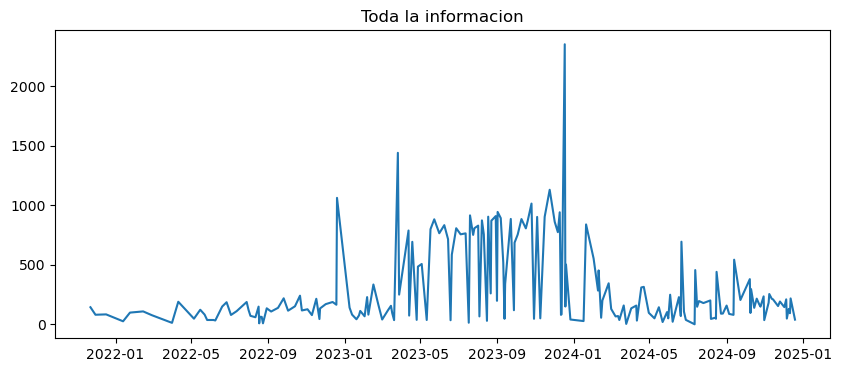

WARNING - (py.warnings._showwarnmsg) - C:\Users\marco\AppData\Local\Temp\ipykernel_28796\4261455078.py:8: FutureWarning: The behavior of DatetimeProperties.to_pydatetime is deprecated, in a future version this will return a Series containing python datetime objects instead of an ndarray. To retain the old behavior, call `np.array` on the result
  plt.plot(demand_df['ds'].dt.to_pydatetime()[:100], demand_df['y'][:100])



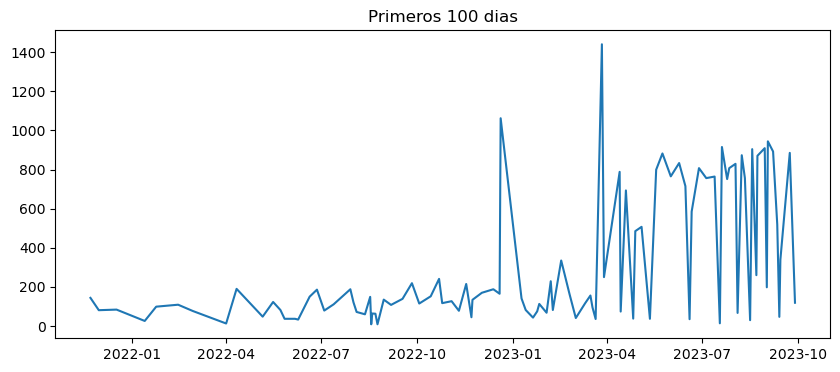

In [56]:
plt.figure(figsize=(10, 4))
plt.title("Toda la informacion")
plt.plot(demand_df['ds'].dt.to_pydatetime(), demand_df['y'])
plt.show()

plt.figure(figsize=(10, 4))
plt.title("Primeros 100 dias")
plt.plot(demand_df['ds'].dt.to_pydatetime()[:100], demand_df['y'][:100])
plt.show()

In [7]:
#  Aca creamos conjunto de validación y prueba para el modelo.

train_size = 0.8

m = NeuralProphet()   # aca crea una instancia del modelo NeuralProphet para mas adelante
df_train, df_valid = demand_df[:int(len(demand_df)*0.8)], demand_df[int(len(demand_df)*0.8):]
df_valid, df_test = df_valid[:len(df_valid)//2], df_valid[len(df_valid)//2:]

# def train_valid_plot():
#     """Visualizando los conjuntos de entrenamiento + validación"""
#     fig = plt.figure(figsize=(10,6))
#     ax = fig.add_subplot(111)
#     ax.plot(df_train['ds'].dt.to_pydatetime(), df_train["y"], color='#1f76b4', label='Set de training')
#     ax.plot(df_valid['ds'].dt.to_pydatetime(), df_valid["y"], color='#fc7d0b', label='Set de validacion')
#     ax.plot(df_test['ds'].dt.to_pydatetime(), df_valid["y"], color='#CDC7E5', label='Set de testeo')
#     ax.legend()
#     plt.show()

# train_valid_plot()

In [ ]:
# aca, entre otras cosas, agregamos al modelo los dias festivos de Australia.

m = NeuralProphet()

m.add_country_holidays(country_name='Brazil')
metrics = m.fit(df=df_train, validation_df=df_valid, freq="D", progress="plot-all")
metrics[-1:]

In [9]:
# Correcta división en train/valid/test (versión con slicing explícito, más clara):
import os
from neuralprophet import NeuralProphet
from pytorch_lightning import loggers as pl_loggers

train_size = int(len(demand_df) * 0.8)
valid_size = (len(demand_df) - train_size) // 2  # División entera.

df_train = demand_df[:train_size]
df_valid = demand_df[train_size : train_size + valid_size]
df_test = demand_df[train_size + valid_size:]

# --- Configuración del directorio de logs (usa una ruta absoluta) ---
log_dir = "/home/mluduena/AST_TP2/ML/my_logs"  # ¡AJUSTA ESTO A TU RUTA REAL!
os.makedirs(log_dir, exist_ok=True)

# --- Creación del logger de TensorBoard ---
tb_logger = pl_loggers.TensorBoardLogger(save_dir=log_dir)

# --- Creación del modelo NeuralProphet ---
m = NeuralProphet(
    # Otras opciones de configuración de NeuralProphet (opcional):
    # epochs=10,       # Número de épocas (si no se especifica, se usa el valor predeterminado)
    # batch_size=32,   # Tamaño del lote (si no se especifica, se usa el valor predeterminado)
    # learning_rate=0.01, # Tasa de aprendizaje (si no, se usa el auto-learning rate finder)
    # ...
)

# --- Agrega feriados nacionales (opcional, si es relevante para tus datos) ---
m.add_country_holidays(country_name='Brazil')  # Cambia 'Brazil' por tu país.

# --- Entrenamiento del modelo (pasando el logger a fit()) ---
metrics = m.fit(
    df=df_train,
    validation_df=df_valid,  # Conjunto de validación.
    freq="D",              # Frecuencia de los datos ('D' para diario, 'H' para horario, etc.)
    progress="plot-all",    # Muestra gráficos de progreso.  Otras opciones: "plot", "notebook", None.
    trainer=tb_logger,    # ¡Pasa el logger aquí!
)

# --- (Opcional) Hacer predicciones y evaluar en el conjunto de prueba ---
# future = m.make_future_dataframe(df=df_train, periods=len(df_test)) # si quiero hacer la prediccion con test
future = m.make_future_dataframe(df=df_train, periods=len(df_valid)) # si quiero hacer la prediccion con valid
forecast = m.predict(future)

# Grafica las predicciones (ejemplo básico)
# import matplotlib.pyplot as plt
# fig_forecast = m.plot(forecast)
# plt.show()

# Imprime las últimas métricas de entrenamiento/validación.
print(metrics[-1:])

TypeError: NeuralProphet.fit() got an unexpected keyword argument 'trainer'

In [ ]:
print(m.config)


# Aca se usa para mostrar la configuración actual del modelo.

In [ ]:
n_epochs_used = len(metrics)
print(f"Número de épocas utilizadas: {n_epochs_used}") # Durante cada epochs, el modelo pasa por todo el conjunto de datos de entrenamiento y ajusta los pesos del modelo para minimizar el error de predicción

In [ ]:
m = NeuralProphet(epochs=30)
m.add_country_holidays(country_name='Australia')
metrics2 = m.fit(df=df_train, validation_df=df_valid, freq="D")
metrics2[-1:]